# Reproduction of Figures from ORFit Paper

# 0. Imports

In [1]:
try:
    import dynamax
    import flax
    import augly
    import torchvision
    from tqdm import tqdm
except ModuleNotFoundError:
    print('installing dynamax')
    %pip install -qq git+https://github.com/probml/dynamax.git
    print('installing flax')
    %pip install flax
    print('installing augly')
    %pip install augly
    print('installing torchvision')
    %pip install torchvision
    print('installing tqdm')
    %pip install tqdm
    import dynamax
    import flax
    import augly
    import torchvision
    from tqdm import tqdm

In [65]:
from typing import Sequence
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import jax.random as jr
from jax import jacrev, vmap, jit
from jax.lax import scan, cond
from jax.flatten_util import ravel_pytree
import flax.linen as nn
from flax.training import train_state
from tqdm import trange
import optax

from rebayes.utils.utils import MLP, get_mlp_flattened_params
from rebayes.utils import datasets
from dynamax.generalized_gaussian_ssm.models import ParamsGGSSM
from dynamax.generalized_gaussian_ssm.inference import EKFIntegrals, conditional_moments_gaussian_filter
from rebayes.orthogonal_recursive_fitting.orfit import RebayesORFit
from rebayes.orthogonal_recursive_fitting.orfit_inference import ORFitParams
from rebayes.base import RebayesParams

In [3]:
def plot_results(ax, result_dict, title, legend_loc=None):
    for key, val in result_dict.items():
        ax.plot(val['rmse'], color=val['color'], ls=val['ls'], label=key)
        ax.fill_between(
            jnp.arange(val['rmse'].shape[0]),
            val['rmse'] - 10*val['rmse_std'],
            val['rmse'] + 10*val['rmse_std'],
            alpha=0.1, color=val['color']
        )

    if legend_loc is not None:
        ax.legend(loc=legend_loc)
    ax.grid()
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 125)
    ax.set_xlabel('Training Steps (samples)')
    ax.set_ylabel('RMSE (deg)')
    ax.set_title(title)

    return ax

## 1. Load Dataset

Heterogenous Dataset

In [4]:
# Load rotated MNIST dataset
np.random.seed(314)
num_train = 100

train, test = datasets.load_rotated_mnist(target_digit=2)
X_train, y_train = train
X_test, y_test = test

X_train = jnp.array(X_train)
y_train = jnp.array(y_train)

idx = jr.choice(jr.PRNGKey(0), X_train.shape[0], shape=(num_train,), replace=False)
# X_train = jnp.array(X_train)[:num_train]
# y_train = jnp.array(y_train)[:num_train]
X_train = jnp.array(X_train)[idx]
y_train = jnp.array(y_train)[idx]

ix_sort = jnp.argsort(y_train)
X_train_inc = X_train[ix_sort]
y_train_inc = y_train[ix_sort]

X_train = (X_train - X_train.mean()) / X_train.std()
X_test = (X_test - X_test.mean()) / X_test.std()

X_train_inc = (X_train_inc - X_train_inc.mean()) / X_train_inc.std()

In [5]:
# Define Linear Regression as single layer perceptron
input_dim_rmnist, hidden_dims_rmnist, output_dim_rmnist = 784, [], 1
model_dims_rmnist = [input_dim_rmnist, *hidden_dims_rmnist, output_dim_rmnist]
_, flat_params_rmnist, _, apply_fn_rmnist = get_mlp_flattened_params(model_dims_rmnist)
print(flat_params_rmnist.shape)

(785,)


# 2. Experiments with Restricted Memory Size

## 2.1 Greedy

In [6]:
def greedy_experiment(key):
    # Random initialization
    _, flat_params_rmnist, _, apply_fn_rmnist = get_mlp_flattened_params(model_dims_rmnist, key=key)

    test_rmses, sample_rmses = [], []

    for i in range(X_train_inc.shape[0]):
        # Test RMSE
        y_pred = jnp.array([y_train_inc[i]] * X_test.shape[0])
        test_rmse = jnp.sqrt(((y_pred - y_test)**2).mean())
        test_rmses.append(test_rmse)

        # RMSE on 16th training sample
        sample_rmse = jnp.sqrt(((y_pred - y_train_inc[15])**2).mean())
        sample_rmses.append(sample_rmse)
    
    return jnp.array(test_rmses), jnp.array(sample_rmses)

In [7]:
# Run 10 Iterations
keys = jr.split(jr.PRNGKey(0), 10)
greedy_test_rmses, greedy_sample_rmses = vmap(greedy_experiment)(keys)

# Compute mean and std over 10 iterations
greedy_test_rmse, greedy_test_rmse_std = greedy_test_rmses.mean(axis=0), greedy_test_rmses.std(axis=0)
greedy_sample_rmse, greedy_sample_rmse_std = greedy_sample_rmses.mean(axis=0), greedy_sample_rmses.std(axis=0)

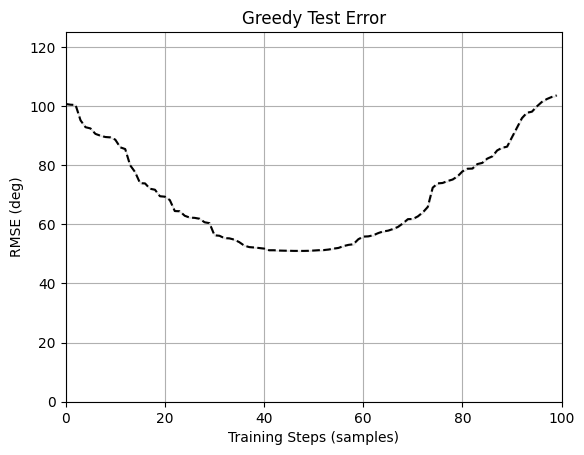

In [30]:
fig, ax = plt.subplots()
greedy_test_result_dict = {
    'Greedy': {
        'rmse': greedy_test_rmse,
        'rmse_std': greedy_test_rmse_std,
        'color': 'k',
        'ls': '--'
    }
}
ax = plot_results(ax, greedy_test_result_dict, 'Greedy Test Error')

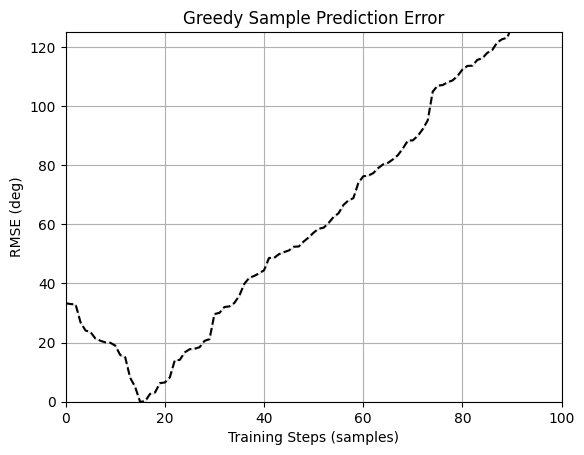

In [32]:
fig, ax = plt.subplots()
greedy_sample_result_dict = {
    'Greedy': {
        'rmse': greedy_sample_rmse,
        'rmse_std': greedy_sample_rmse_std,
        'color': 'k',
        'ls': '--'
    }
}
ax = plot_results(ax, greedy_sample_result_dict, 'Greedy Sample Prediction Error')

## 2.2 One-Step SGD

In [135]:
_stable_division = lambda a, b: jnp.where(b.any(), a / b, jnp.zeros(shape=a.shape))

def os_sgd_experiment(key, sample_indx=15):
    # Random initialization
    _, params, _, apply_fn_rmnist = get_mlp_flattened_params(model_dims_rmnist, key=key)

    train_rmses, test_rmses, sample_rmses = [], [], []

    for i in range(X_train_inc.shape[0]):
        f_fn = lambda w: apply_fn_rmnist(w, X_train_inc[i])
        v = jacrev(f_fn)(params).squeeze()

        # Update params
        params = params - _stable_division((f_fn(params) - y_train_inc[i]) * v, v.T @ v)

        # Train RMSE
        y_train_pred = vmap(apply_fn_rmnist, (None, 0))(params, X_train_inc).squeeze()
        train_rmse = jnp.sqrt(((y_train_pred - y_train_inc)**2).mean())
        train_rmses.append(train_rmse)

        # Test RMSE
        y_test_pred = vmap(apply_fn_rmnist, (None, 0))(params, X_test).squeeze()
        test_rmse = jnp.sqrt(((y_test_pred - y_test)**2).mean())
        test_rmses.append(test_rmse)

        # RMSE on 16th training sample
        y_sample_pred = apply_fn_rmnist(params, X_train_inc[sample_indx]).squeeze()
        sample_rmse = jnp.sqrt((y_sample_pred - y_train_inc[sample_indx])**2)
        sample_rmses.append(sample_rmse)

    return jnp.array(train_rmses), jnp.array(test_rmses), jnp.array(sample_rmses)

In [136]:
# Run 10 Iterations
keys = jr.split(jr.PRNGKey(0), 10)
_, os_sgd_test_rmses, os_sgd_sample_rmses = vmap(os_sgd_experiment)(keys)

# Compute mean and std over 10 iterations
os_sgd_test_rmse, os_sgd_test_rmse_std = os_sgd_test_rmses.mean(axis=0), os_sgd_test_rmses.std(axis=0)
os_sgd_sample_rmse, os_sgd_sample_rmse_std = os_sgd_sample_rmses.mean(axis=0), os_sgd_sample_rmses.std(axis=0)

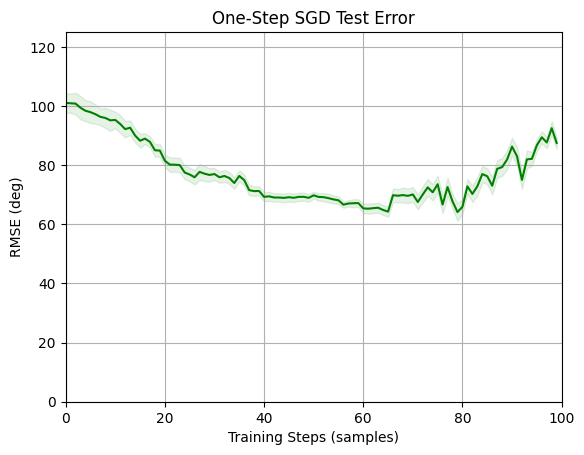

In [137]:
fig, ax = plt.subplots()
os_sgd_test_result_dict = {
    'One-Step SGD': {
        'rmse': os_sgd_test_rmse,
        'rmse_std': os_sgd_test_rmse_std,
        'color': 'g',
        'ls': '-'
    }
}
ax = plot_results(ax, os_sgd_test_result_dict, 'One-Step SGD Test Error')

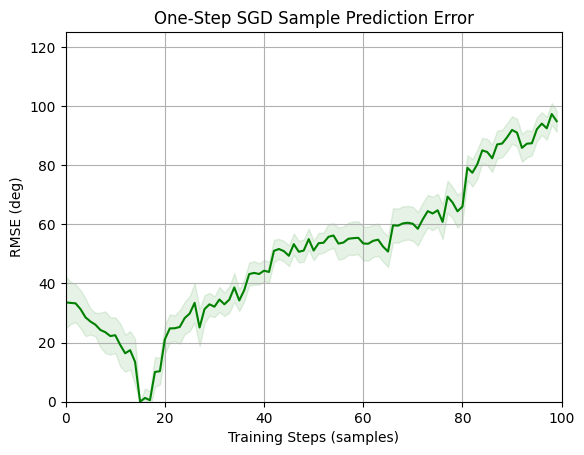

In [138]:
fig, ax = plt.subplots()
os_sgd_sample_result_dict = {
    'One-Step SGD': {
        'rmse': os_sgd_sample_rmse,
        'rmse_std': os_sgd_sample_rmse_std,
        'color': 'g',
        'ls': '-'
    }
}
ax = plot_results(ax, os_sgd_sample_result_dict, 'One-Step SGD Sample Prediction Error')

## 2.3 ORFit-Random

In [12]:
_jacrev_2d = lambda f, x: jnp.atleast_2d(jacrev(f)(x))
_stable_division = lambda a, b: jnp.where(b.any(), a / b, jnp.zeros(shape=a.shape))
_normalize = lambda v: jnp.where(v.any(), v / jnp.linalg.norm(v), jnp.zeros(shape=v.shape))
_projection_matrix = lambda a: _stable_division(a.reshape(-1, 1) @ a.reshape(1, -1), a.T @ a)
_project = lambda a, x: _stable_division(a * (a.T @ x), (a.T @ a))
_project_to_columns = lambda A, x: \
    jnp.where(A.any(), vmap(_project, (1, None))(A, x).sum(axis=0), jnp.zeros(shape=x.shape))

In [13]:
# # Randomly choose from full set of columns at each step
# def _orfit_random_update(m, U, apply_fn, x, y, memory_size, key):
#     if isinstance(key, int):
#         key = jr.PRNGKey(key)

#     f_fn = lambda w: apply_fn(w, x)

#     # Compute Jacobians and project out the orthogonal components
#     v = jacrev(f_fn)(m).squeeze()
#     if U.any():
#         if U.shape[1] > memory_size:
#             # Randomly select columns
#             cols = jr.choice(key, jnp.arange(U.shape[1]), shape=(memory_size,), replace=False)
#             U_choice = U[:, cols]
#             v_prime = v - _project_to_columns(U_choice, v)
#         else:
#             v_prime = v - _project_to_columns(U, v)
#     else:
#         v_prime = v

#     # Update the full U matrix
#     u = _normalize(v_prime)
#     if U.any():
#         U = jnp.column_stack([U, u])
#     else:
#         U = jnp.atleast_2d(u).T
    
#     # Update the parameters
#     m_cond = m - _stable_division((f_fn(m) - y) * v_prime, v.T @ v_prime)

#     return m_cond, U

In [14]:
# Randomly replace columns in limited-memory U at each step
def _orfit_random_update(m, U, apply_fn, x, y, memory_size, key):
    if isinstance(key, int):
        key = jr.PRNGKey(key)

    f_fn = lambda w: apply_fn(w, x)

    # Compute Jacobians and project out the orthogonal components
    v = jacrev(f_fn)(m).squeeze()
    if U.any():
        v_prime = v - _project_to_columns(U, v)
    else:
        v_prime = v

    # Update the full U matrix
    u = _normalize(v_prime)
    if U.any():
        U = jnp.column_stack([U, u])
    else:
        U = jnp.atleast_2d(u).T
    if U.shape[1] > memory_size:
        # Randomly select columns
        cols = jr.choice(key, jnp.arange(U.shape[1]), shape=(memory_size,), replace=False)
        U = U[:, cols]
    
    # Update the parameters
    m_cond = m - _stable_division((f_fn(m) - y) * v_prime, v.T @ v_prime)

    return m_cond, U

In [15]:
def random_orfit_experiment(key):
    # Random initialization
    _, params, _, apply_fn_rmnist = get_mlp_flattened_params(model_dims_rmnist, key=key)
    U = jnp.array([[]])

    test_rmses, sample_rmses = [], []

    for i in range(X_train_inc.shape[0]):
        # Update params
        params, U = _orfit_random_update(params, U, apply_fn_rmnist, X_train_inc[i], y_train_inc[i], 10, i)

        # Test RMSE
        y_test_pred = vmap(apply_fn_rmnist, (None, 0))(params, X_test).squeeze()
        test_rmse = jnp.sqrt(((y_test_pred - y_test)**2)).mean()
        test_rmses.append(test_rmse)

        # RMSE on 16th training sample
        y_sample_pred = apply_fn_rmnist(params, X_train_inc[15]).squeeze()
        sample_rmse = jnp.sqrt(((y_sample_pred - y_train_inc[15])**2))
        sample_rmses.append(sample_rmse)

    return jnp.array(test_rmses), jnp.array(sample_rmses)

In [16]:
# Run 10 Iterations
keys = jr.split(jr.PRNGKey(0), 10)
random_orfit_test_rmses, random_orfit_sample_rmses = vmap(random_orfit_experiment)(keys)

# Compute mean and std over 10 iterations
random_orfit_test_rmse, random_orfit_test_rmse_std = random_orfit_test_rmses.mean(axis=0), random_orfit_test_rmses.std(axis=0)
random_orfit_sample_rmse, random_orfit_sample_rmse_std = random_orfit_sample_rmses.mean(axis=0), random_orfit_sample_rmses.std(axis=0)

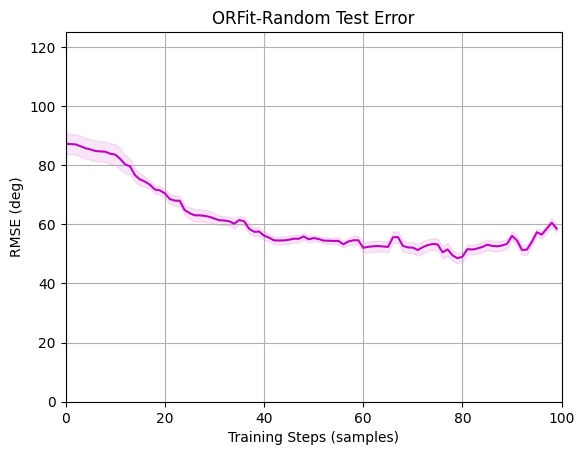

In [35]:
fig, ax = plt.subplots()
random_orfit_test_result_dict = {
    'ORFit-Random': {
        'rmse': random_orfit_test_rmse,
        'rmse_std': random_orfit_test_rmse_std,
        'color': 'm',
        'ls': '-',
    }
}
ax = plot_results(ax, random_orfit_test_result_dict, 'ORFit-Random Test Error')

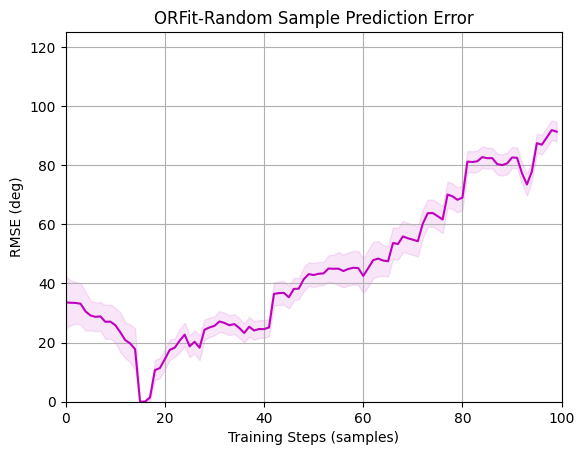

In [36]:
fig, ax = plt.subplots()
random_orfit_sample_result_dict = {
    'ORFit-Random': {
        'rmse': random_orfit_sample_rmse,
        'rmse_std': random_orfit_sample_rmse_std,
        'color': 'm',
        'ls': '-',
    }
}
ax = plot_results(ax, random_orfit_sample_result_dict, 'ORFit-Random Sample Prediction Error')

## 2.4 ORFit-Latest

In [17]:
def _orfit_latest_update(m, U, apply_fn, x, y, memory_size):
    f_fn = lambda w: apply_fn(w, x)

    # Compute Jacobians and project out the orthogonal components
    v = jacrev(f_fn)(m).squeeze()
    if U.any():
        v_prime = v - _project_to_columns(U, v)
    else:
        v_prime = v

    # Update the full U matrix
    u = _normalize(v_prime)
    if U.any():
        U = jnp.column_stack([U, u])
    else:
        U = jnp.atleast_2d(u).T
    U = U[:, -memory_size:]
    
    # Update the parameters
    m_cond = m - _stable_division((f_fn(m) - y) * v_prime, v.T @ v_prime)

    return m_cond, U

In [18]:
def latest_orfit_experiment(key):
    # Random initialization
    _, params, _, apply_fn_rmnist = get_mlp_flattened_params(model_dims_rmnist, key=key)
    U = jnp.array([[]])

    test_rmses, sample_rmses = [], []

    for i in range(X_train_inc.shape[0]):
        # Update params
        params, U = _orfit_latest_update(params, U, apply_fn_rmnist, X_train_inc[i], y_train_inc[i], 10)

        # Test RMSE
        y_test_pred = vmap(apply_fn_rmnist, (None, 0))(params, X_test).squeeze()
        test_rmse = jnp.sqrt(((y_test_pred - y_test)**2)).mean()
        test_rmses.append(test_rmse)

        # RMSE on 16th training sample
        y_sample_pred = apply_fn_rmnist(params, X_train_inc[15]).squeeze()
        sample_rmse = jnp.sqrt(((y_sample_pred - y_train_inc[15])**2))
        sample_rmses.append(sample_rmse)

    return jnp.array(test_rmses), jnp.array(sample_rmses)

In [19]:
# Run 10 Iterations
keys = jr.split(jr.PRNGKey(0), 10)
latest_orfit_test_rmses, latest_orfit_sample_rmses = vmap(latest_orfit_experiment)(keys)

# Compute mean and std over 10 iterations
latest_orfit_test_rmse, latest_orfit_test_rmse_std = latest_orfit_test_rmses.mean(axis=0), latest_orfit_test_rmses.std(axis=0)
latest_orfit_sample_rmse, latest_orfit_sample_rmse_std = latest_orfit_sample_rmses.mean(axis=0), latest_orfit_sample_rmses.std(axis=0)

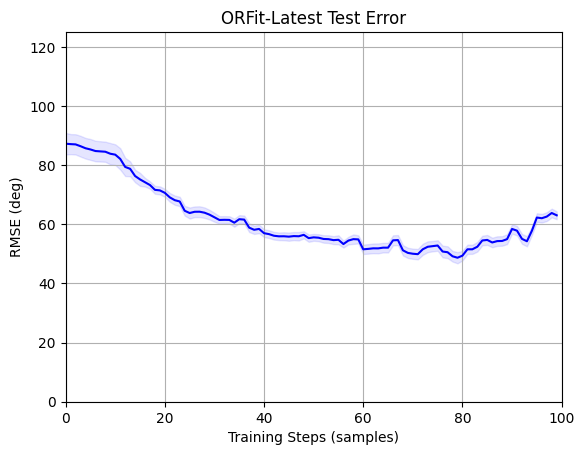

In [37]:
fig, ax = plt.subplots()
latest_orfit_test_result_dict = {
    'ORFit-Latest': {
        'rmse': latest_orfit_test_rmse,
        'rmse_std': latest_orfit_test_rmse_std,
        'color': 'b',
        'ls': '-',
    }
}
ax = plot_results(ax, latest_orfit_test_result_dict, 'ORFit-Latest Test Error')

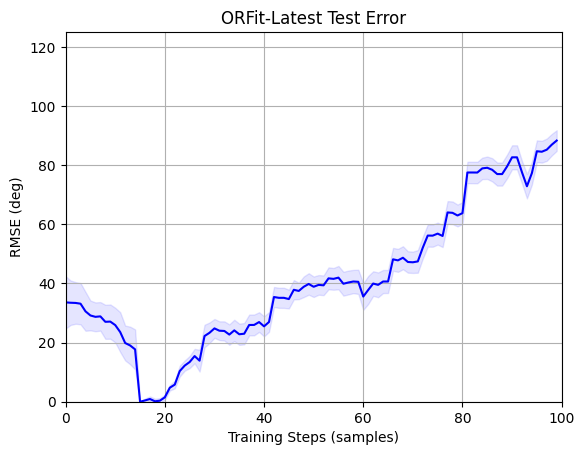

In [38]:
fig, ax = plt.subplots()
latest_orfit_sample_result_dict = {
    'ORFit-Latest': {
        'rmse': latest_orfit_sample_rmse,
        'rmse_std': latest_orfit_sample_rmse_std,
        'color': 'b',
        'ls': '-',
    }
}
ax = plot_results(ax, latest_orfit_sample_result_dict, 'ORFit-Latest Test Error')

## 2.5 ORFit-Linear

In [20]:
def orfit_experiment(model_dims, key):
    # Random initialization
    _, params, _, apply_fn_rmnist = get_mlp_flattened_params(model_dims, key=key)
    model_params_linear = RebayesParams(
        initial_mean=params,
        initial_covariance=None,
        dynamics_weights=None,
        dynamics_covariance=None,
        emission_mean_function=apply_fn_rmnist,
        emission_cov_function=None,
    )
    orfit_params_linear = ORFitParams(
        memory_size=10,
        sv_threshold=0.0
    )
    estimator = RebayesORFit(model_params_linear, orfit_params_linear, method='orfit')

    test_rmses, sample_rmses = [], []

    bel = estimator.init_bel()
    for i in range(X_train_inc.shape[0]):
        # Update params
        bel = estimator.update_state(bel, X_train_inc[i], y_train_inc[i])

        # Test RMSE
        y_test_pred = vmap(apply_fn_rmnist, (None, 0))(bel.mean, X_test).squeeze()
        test_rmse = jnp.sqrt(((y_test_pred - y_test)**2)).mean()
        test_rmses.append(test_rmse)

        # RMSE on 16th training sample
        y_sample_pred = apply_fn_rmnist(bel.mean, X_train_inc[15]).squeeze()
        sample_rmse = jnp.sqrt(((y_sample_pred - y_train_inc[15])**2))
        sample_rmses.append(sample_rmse)
    
    return jnp.array(test_rmses), jnp.array(sample_rmses)

In [21]:
# Run 10 Iterations
keys = jr.split(jr.PRNGKey(0), 10)
orfit_test_rmses, orfit_sample_rmses = vmap(orfit_experiment, (None, 0))(model_dims_rmnist, keys)

# Compute mean and std over 10 iterations
orfit_test_rmse, orfit_test_rmse_std = orfit_test_rmses.mean(axis=0), orfit_test_rmses.std(axis=0)
orfit_sample_rmse, orfit_sample_rmse_std = orfit_sample_rmses.mean(axis=0), orfit_sample_rmses.std(axis=0)

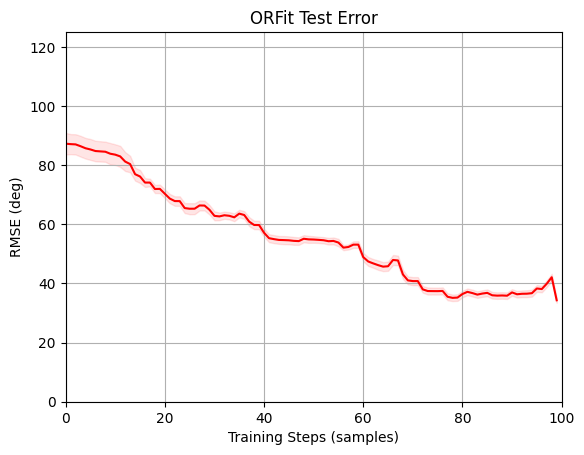

In [40]:
fig, ax = plt.subplots()
orfit_test_result_dict = {
    'ORFit': {
        'rmse': orfit_test_rmse,
        'rmse_std': orfit_test_rmse_std,
        'color': 'r',
        'ls': '-',
    }
}
ax = plot_results(ax, orfit_test_result_dict, 'ORFit Test Error')

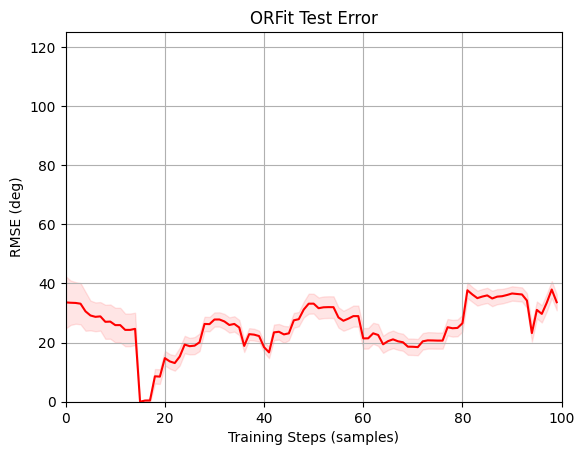

In [41]:
fig, ax = plt.subplots()
orfit_sample_result_dict = {
    'ORFit': {
        'rmse': orfit_sample_rmse,
        'rmse_std': orfit_sample_rmse_std,
        'color': 'r',
        'ls': '-',
    }
}
ax = plot_results(ax, orfit_sample_result_dict, 'ORFit Test Error')

## 2.6 ORFit Non-Linear

In [53]:
# Define Non Linear Model
model_dims_nl = [784, 10_000, 1]

# Run 10 Iterations
keys = jr.split(jr.PRNGKey(0), 10)
nl_orfit_test_rmses, nl_orfit_sample_rmses = vmap(orfit_experiment, (None, 0))(model_dims_nl, keys)

# Compute mean and std over 10 iterations
nl_orfit_test_rmse, nl_orfit_test_rmse_std = nl_orfit_test_rmses.mean(axis=0), nl_orfit_test_rmses.std(axis=0)
nl_orfit_sample_rmse, nl_orfit_sample_rmse_std = nl_orfit_sample_rmses.mean(axis=0), nl_orfit_sample_rmses.std(axis=0)

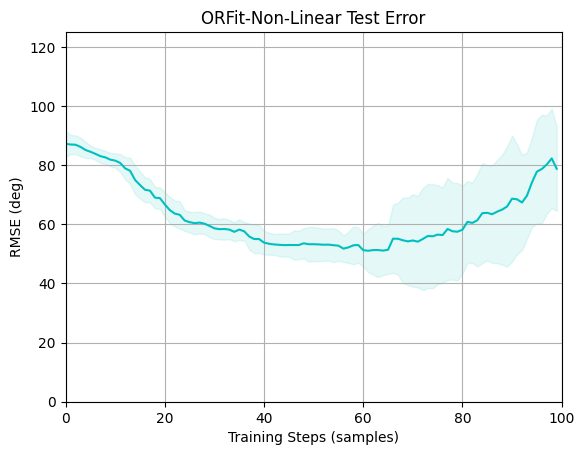

In [54]:
fig, ax = plt.subplots()
nl_orfit_test_result_dict = {
    'ORFit-Non-Linear': {
        'rmse': nl_orfit_test_rmse,
        'rmse_std': nl_orfit_test_rmse_std,
        'color': 'c',
        'ls': '-',
    }
}
ax = plot_results(ax, nl_orfit_test_result_dict, 'ORFit-Non-Linear Test Error')

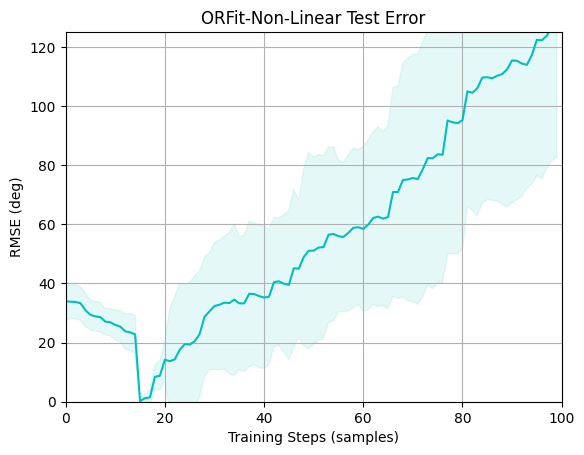

In [55]:
fig, ax = plt.subplots()
nl_orfit_sample_result_dict = {
    'ORFit-Non-Linear': {
        'rmse': nl_orfit_sample_rmse,
        'rmse_std': nl_orfit_sample_rmse_std,
        'color': 'c',
        'ls': '-',
    }
}
ax = plot_results(ax, nl_orfit_sample_result_dict, 'ORFit-Non-Linear Test Error')

## 2.7 Model Comparison

Figure 2(a)

In [56]:
test_result_dict = {
    **greedy_test_result_dict,
    **os_sgd_test_result_dict,
    **random_orfit_test_result_dict,
    **latest_orfit_test_result_dict,
    **orfit_test_result_dict,
    **nl_orfit_test_result_dict,
}

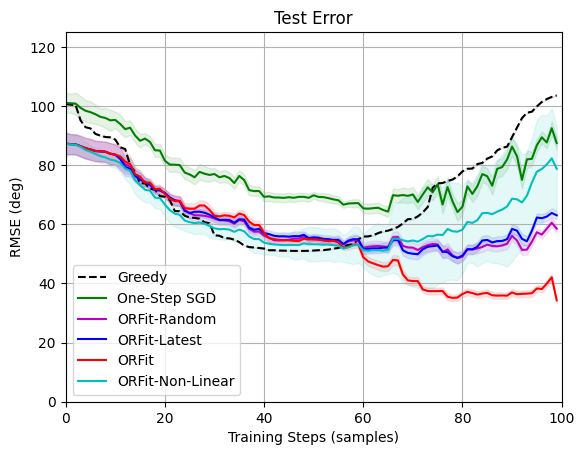

In [57]:
fig, ax = plt.subplots()
ax = plot_results(ax, test_result_dict, 'Test Error', legend_loc=3)

Figure 2(b)

In [58]:
sample_result_dict = {
    **greedy_sample_result_dict,
    **os_sgd_sample_result_dict,
    **random_orfit_sample_result_dict,
    **latest_orfit_sample_result_dict,
    **orfit_sample_result_dict,
    **nl_orfit_sample_result_dict,
}

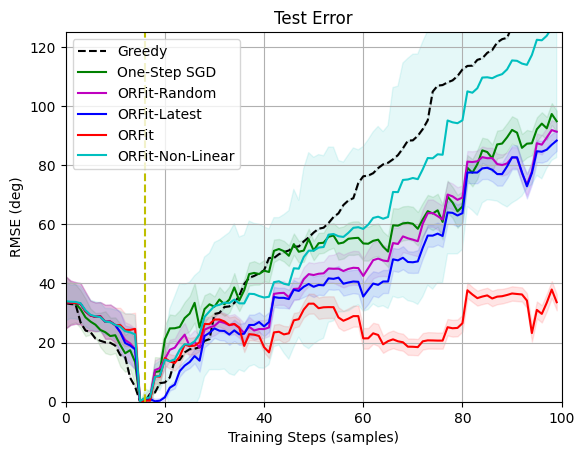

In [59]:
fig, ax = plt.subplots()
ax = plot_results(ax, sample_result_dict, 'Test Error', legend_loc=2)
ax.axvline(x=16, color='y', linestyle='--');

# 3. Experiments without Memory Restriction

## 3.1 Vanilla SGD

In [155]:
@jit
def compute_loss_and_updates_sgd(state, x, y):
    def loss_fn(params):
        pred = state.apply_fn(params, x).squeeze()
        loss = jnp.mean(optax.l2_loss(pred, y))
        return loss, pred

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, pred), grads = grad_fn(state.params)
    return grads

In [156]:
def train_model(state, X_train, y_train, callback=None):
    @jit
    def apply_updates(state, updates):
        return state.apply_gradients(grads=updates)

    outputs = []
    for i in trange(len(X_train)):
        x, y = X_train[i], y_train[i]
        updates = compute_loss_and_updates_sgd(state, x, y)
        state = apply_updates(state, updates)

        output = None
        if callback is not None:
            output = callback(state)
        outputs.append(output)
    
    return state, jnp.array(outputs)

In [157]:
tx = optax.sgd(learning_rate=1e-5)
opt_state = train_state.TrainState.create(apply_fn=apply_fn_rmnist, params=flat_params_rmnist, tx=tx)
@jit
def sgd_callback(state):
    # Compute Train Error
    y_train_pred = vmap(state.apply_fn, (None, 0))(state.params, X_train_inc).squeeze()
    train_rmse = jnp.sqrt(((y_train_pred - y_train_inc)**2).mean())

    # Compute Test Error
    y_test_pred = vmap(state.apply_fn, (None, 0))(state.params, X_test).squeeze()
    test_rmse = jnp.sqrt(((y_test_pred - y_test)**2).mean())

    # RMSE on 11th training sample
    y_sample_pred = state.apply_fn(state.params, X_train_inc[10]).squeeze()
    sample_rmse = jnp.sqrt((y_sample_pred - y_train_inc[10])**2)

    return train_rmse, test_rmse, sample_rmse

# Stack data
X_train_sgd, y_train_sgd = jnp.tile(X_train_inc, (1000, 1)), jnp.tile(y_train_inc, 1000)

In [158]:
def sgd_experiment(key):
    # Initialize Model
    _, params, _, apply_fn = get_mlp_flattened_params(model_dims_rmnist, key=key)

    # Initialize Optimizer
    tx = optax.sgd(learning_rate=1e-5)
    opt_state = train_state.TrainState.create(apply_fn=apply_fn, params=params, tx=tx)

    # Train Model
    opt_state, outputs = train_model(opt_state, X_train_sgd, y_train_sgd, callback=sgd_callback)

    # Extract outputs
    train_rmses, test_rmses, sample_rmses = outputs[:, 0], outputs[:, 1], outputs[:, 2]
    return train_rmses, test_rmses, sample_rmses

In [159]:
# Run 10 Iterations
keys = jr.split(jr.PRNGKey(0), 10)
sgd_train_rmses, sgd_test_rmses, sgd_sample_rmses = jax.vmap(sgd_experiment)(keys)

# Compute mean and std over 10 iterations
sgd_train_rmse, sgd_train_rmse_std = sgd_train_rmses.mean(axis=0), sgd_train_rmses.std(axis=0)
sgd_test_rmse, sgd_test_rmse_std = sgd_test_rmses.mean(axis=0), sgd_test_rmses.std(axis=0)
sgd_sample_rmse, sgd_sample_rmse_std = sgd_sample_rmses.mean(axis=0), sgd_sample_rmses.std(axis=0)

100%|██████████| 100000/100000 [01:52<00:00, 885.10it/s]


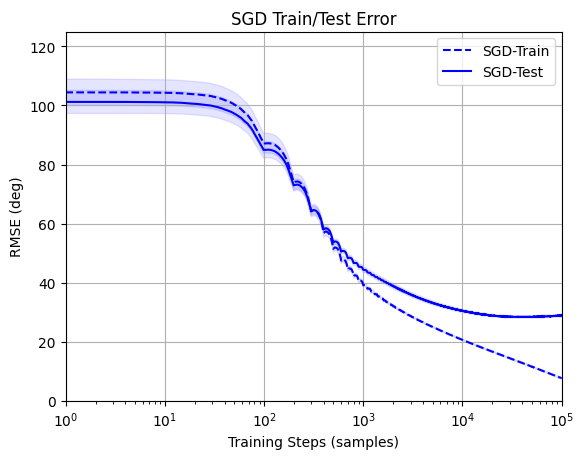

In [165]:
fig, ax = plt.subplots()
sgd_train_test_result_dict = {
    'SGD-Train': {
        'rmse': sgd_train_rmse,
        'rmse_std': sgd_train_rmse_std,
        'color': 'b',
        'ls': '--',
    },
    'SGD-Test': {
        'rmse': sgd_test_rmse,
        'rmse_std': sgd_test_rmse_std,
        'color': 'b',
        'ls': '-',
    },
}
ax = plot_results(ax, sgd_train_test_result_dict, 'SGD Train/Test Error', legend_loc=1)
ax.set_xscale('log')
ax.set_xlim(1, 100_000);

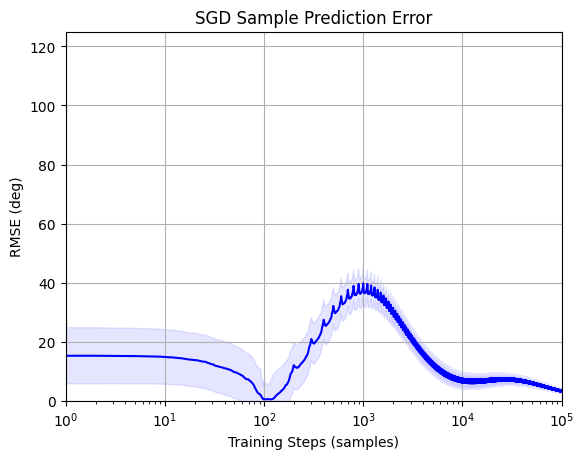

In [167]:
fig, ax = plt.subplots()
sgd_sample_result_dict = {
    'SGD': {
        'rmse': sgd_sample_rmse,
        'rmse_std': sgd_sample_rmse_std,
        'color': 'b',
        'ls': '-',
    },
}
ax = plot_results(ax, sgd_sample_result_dict, 'SGD Sample Prediction Error')
ax.set_xscale('log')
ax.set_xlim(1, 100_000);

## 3.2 One-Step SGD

In [139]:
# Run 10 Iterations
keys = jr.split(jr.PRNGKey(0), 10)
fm_os_sgd_train_rmses, fm_os_sgd_test_rmses, fm_os_sgd_sample_rmses = \
    vmap(partial(os_sgd_experiment, sample_indx=10))(keys)

# Compute mean and std over 10 iterations
fm_os_sgd_train_rmse, fm_os_sgd_train_rmse_std = fm_os_sgd_train_rmses.mean(axis=0), fm_os_sgd_train_rmses.std(axis=0)
fm_os_sgd_test_rmse, fm_os_sgd_test_rmse_std = fm_os_sgd_test_rmses.mean(axis=0), fm_os_sgd_test_rmses.std(axis=0)
fm_os_sgd_sample_rmse, fm_os_sgd_sample_rmse_std = fm_os_sgd_sample_rmses.mean(axis=0), fm_os_sgd_sample_rmses.std(axis=0)

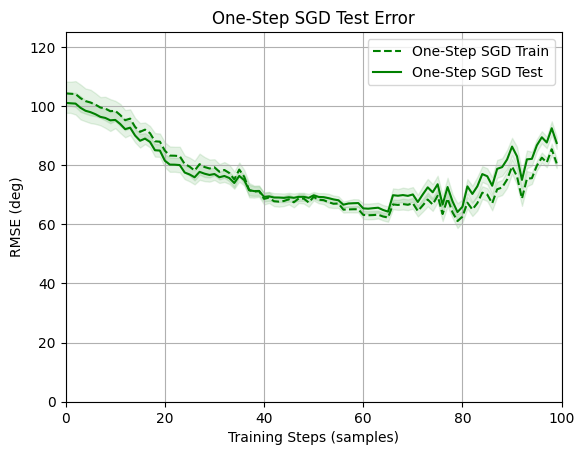

In [140]:
fig, ax = plt.subplots()
fm_os_sgd_train_test_result_dict = {
    'One-Step SGD Train': {
        'rmse': fm_os_sgd_train_rmse,
        'rmse_std': fm_os_sgd_train_rmse_std,
        'color': 'g',
        'ls': '--'
    },
    'One-Step SGD Test': {
        'rmse': fm_os_sgd_test_rmse,
        'rmse_std': fm_os_sgd_test_rmse_std,
        'color': 'g',
        'ls': '-'
    }
}
ax = plot_results(ax, fm_os_sgd_train_test_result_dict, 'One-Step SGD Test Error', legend_loc=1)

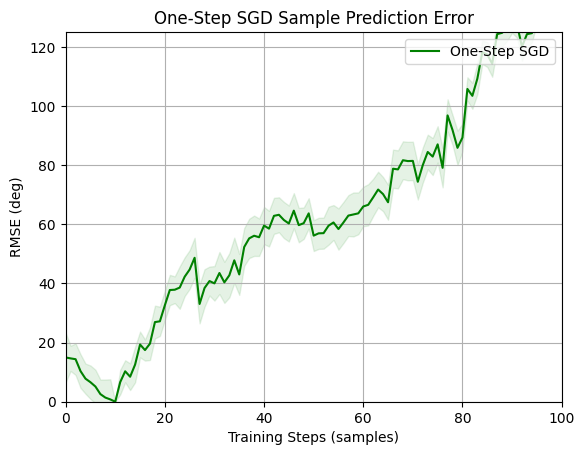

In [141]:
fig, ax = plt.subplots()
fm_os_sgd_sample_result_dict = {
    'One-Step SGD': {
        'rmse': fm_os_sgd_sample_rmse,
        'rmse_std': fm_os_sgd_sample_rmse_std,
        'color': 'g',
        'ls': '-'
    }
}
ax = plot_results(ax, fm_os_sgd_sample_result_dict, 'One-Step SGD Sample Prediction Error', legend_loc=1)


## 3.3 Full-Memory ORFit

In [108]:
def full_memory_orfit_experiment(model_dims, key):
    # Random initialization
    _, params, _, apply_fn_rmnist = get_mlp_flattened_params(model_dims, key=key)
    model_params_linear = RebayesParams(
        initial_mean=params,
        initial_covariance=None,
        dynamics_weights=None,
        dynamics_covariance=None,
        emission_mean_function=apply_fn_rmnist,
        emission_cov_function=None,
    )
    orfit_params_linear = ORFitParams(
        memory_size=100,
        sv_threshold=0.0
    )
    estimator = RebayesORFit(model_params_linear, orfit_params_linear, method='orfit')

    train_rmses, test_rmses, sample_rmses = [], [], []

    bel = estimator.init_bel()
    for i in range(X_train_inc.shape[0]):
        # Update params
        bel = estimator.update_state(bel, X_train_inc[i], y_train_inc[i])

        # Train RMSE
        y_train_pred = vmap(apply_fn_rmnist, (None, 0))(bel.mean, X_train_inc).squeeze()
        train_rmse = jnp.sqrt(((y_train_pred - y_train_inc)**2)).mean()
        train_rmses.append(train_rmse)

        # Test RMSE
        y_test_pred = vmap(apply_fn_rmnist, (None, 0))(bel.mean, X_test).squeeze()
        test_rmse = jnp.sqrt(((y_test_pred - y_test)**2)).mean()
        test_rmses.append(test_rmse)

        # RMSE on 16th training sample
        y_sample_pred = apply_fn_rmnist(bel.mean, X_train_inc[10]).squeeze()
        sample_rmse = jnp.sqrt(((y_sample_pred - y_train_inc[10])**2))
        sample_rmses.append(sample_rmse)
    
    return jnp.array(train_rmses), jnp.array(test_rmses), jnp.array(sample_rmses)

In [109]:
# Run 10 Iterations
keys = jr.split(jr.PRNGKey(0), 10)
fm_orfit_train_rmses, fm_orfit_test_rmses, fm_orfit_sample_rmses = vmap(full_memory_orfit_experiment, (None, 0))(model_dims_rmnist, keys)

# Compute mean and std over 10 iterations
fm_orfit_train_rmse, fm_orfit_train_rmse_std = fm_orfit_train_rmses.mean(axis=0), fm_orfit_train_rmses.std(axis=0)
fm_orfit_test_rmse, fm_orfit_test_rmse_std = fm_orfit_test_rmses.mean(axis=0), fm_orfit_test_rmses.std(axis=0)
fm_orfit_sample_rmse, fm_orfit_sample_rmse_std = fm_orfit_sample_rmses.mean(axis=0), fm_orfit_sample_rmses.std(axis=0)

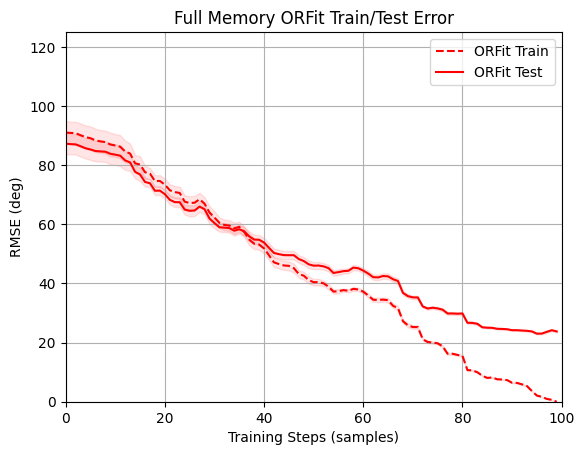

In [110]:
fig, ax = plt.subplots()
fm_orfit_train_test_result_dict = {
    'ORFit Train': {
        'rmse': fm_orfit_train_rmse,
        'rmse_std': fm_orfit_train_rmse_std,
        'color': 'r',
        'ls': '--',
    },
    'ORFit Test': {
        'rmse': fm_orfit_test_rmse,
        'rmse_std': fm_orfit_test_rmse_std,
        'color': 'r',
        'ls': '-',
    }
}
ax = plot_results(ax, fm_orfit_train_test_result_dict, 'Full Memory ORFit Train/Test Error', legend_loc=1)

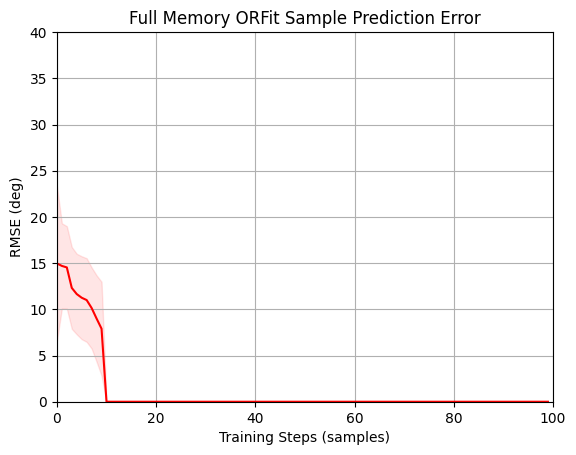

In [129]:
fig, ax = plt.subplots()
fm_orfit_sample_result_dict = {
    'ORFit': {
        'rmse': fm_orfit_sample_rmse,
        'rmse_std': fm_orfit_sample_rmse_std,
        'color': 'r',
        'ls': '-',
    }
}
ax = plot_results(ax, fm_orfit_sample_result_dict, 'Full Memory ORFit Sample Prediction Error')
ax.set_ylim(0, 40);

## 3.4 Model Comparison

Figure 3(a)

In [168]:
fm_train_test_result_dict = {
    **sgd_train_test_result_dict,
    **fm_os_sgd_train_test_result_dict,
    **fm_orfit_train_test_result_dict,
}

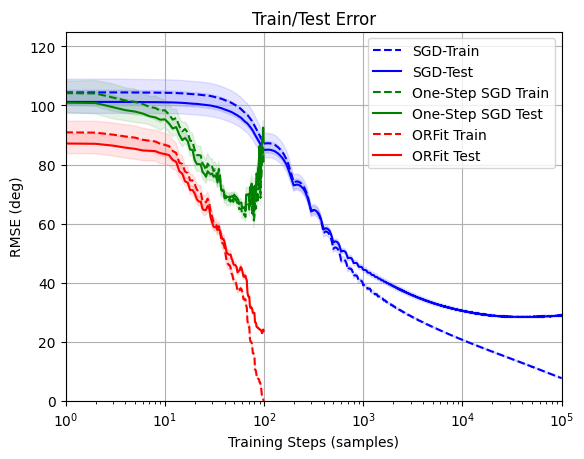

In [169]:
fig, ax = plt.subplots()
ax = plot_results(ax, fm_train_test_result_dict, 'Train/Test Error', legend_loc=1)
ax.set_xscale('log')
ax.set_xlim(1, 100_000);

Figure 3(b)

In [170]:
fm_sample_result_dict = {
    **sgd_sample_result_dict,
    **fm_os_sgd_sample_result_dict,
    **fm_orfit_sample_result_dict,
}

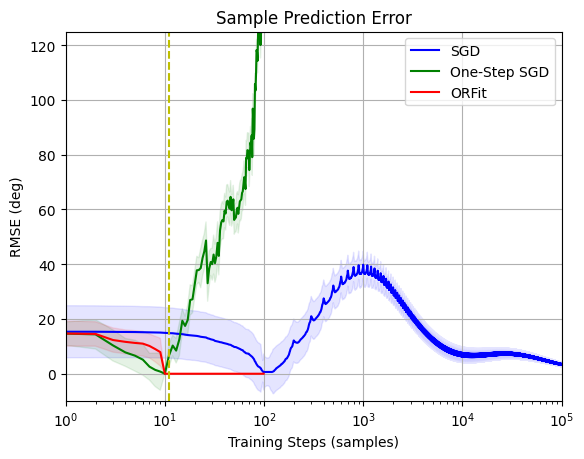

In [171]:
fig, ax = plt.subplots()
ax = plot_results(ax, fm_sample_result_dict, 'Sample Prediction Error', legend_loc=1)

ax.axvline(x=11, color='y', linestyle='--')
ax.set_xscale('log')
ax.set_xlim(1, 100_000)
ax.set_ylim(-10, 125);